# 01 — MVP Forecasting with Yahoo Finance Data

**Goal:** Build a **Minimum Viable Product Forecasting pipeline** with:
- Data from Yahoo Finance (proxy for electricity futures, e.g., ETF `XLE`)
- Baseline ARIMA model
- Machine Learning model (LightGBM)
- Metrics & visual comparison

**Why this matters for hedge funds:**
- Demonstrates ability to structure time series forecasting projects
- Shows competence in classical + ML approaches
- Provides a baseline for extension with real energy data (ENTSO‑E, EEX, etc.)


## 0) Setup & Imports
- Import core libraries (`pandas`, `numpy`, `matplotlib`).
- Load `yfinance` (for data), `pmdarima` (ARIMA), and `lightgbm` (ML model).

**Why:**  
We need data access + modeling libraries.  
ARIMA = statistical baseline, LightGBM = machine learning baseline.


In [2]:
# Install dependencies (with fixed compatible versions)
# %pip install numpy==1.26.4 scipy==1.13.1 scikit-learn==1.5.1 pmdarima==2.0.4 lightgbm yfinance matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import os

from pmdarima import auto_arima
import lightgbm as lgb

plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['axes.grid'] = True

## 1) Helper functions

In [3]:
def add_time_features(df, ts_col="Date"):
    df = df.copy()
    df[ts_col] = pd.to_datetime(df[ts_col])
    df["year"] = df[ts_col].dt.year
    df["month"] = df[ts_col].dt.month
    df["dayofweek"] = df[ts_col].dt.dayofweek
    return df

def make_lags(df, y_col="Close", lags=(1,5,22)):
    df = df.copy()
    for L in lags:
        df[f"lag_{L}"] = df[y_col].shift(L)
    return df

def ts_train_test_split(df, test_size=0.2):
    n = len(df)
    split = int(n*(1-test_size))
    return df.iloc[:split].copy(), df.iloc[split:].copy()

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape}


- `add_time_features`: adds calendar features (year, month, day of week) extracting them from the date column.  
- `make_lags`: creates lagged variables (yesterday’s price, last week’s price, last trading month's price). For each lag a new column is created 
- `ts_train_test_split`: splits the dataset chronologically (train/test).  
- `metrics`: computes MAE, RMSE, and MAPE for evaluation.  

**Why:**  
- Time features capture seasonality/trends.  
- Lag features let ML models “see” the past.  
- Train/test split ensures no leakage from future → past.  
- Metrics allow comparison between models.

## 2) Download data from Yahoo Finance

In [4]:
TICKER = "XLE"  # Proxy energy ETF
df = yf.download(TICKER, start="2015-01-01", auto_adjust=True).reset_index()
df = df[["Date", "Close"]].dropna().reset_index(drop=True)


# Make sure the folder exists
os.makedirs("../data", exist_ok=True)

# Take the last 1 year of data as sample
sample = df[df["Date"] >= (df["Date"].max() - pd.Timedelta(days=365))]

# Save to CSV
sample.to_csv("../data/xle_sample.csv")

print("Sample dataset saved in data/xle_sample.csv")
df.head()

[*********************100%***********************]  1 of 1 completed

Sample dataset saved in data/xle_sample.csv


Price,Date,Close
Ticker,,XLE
0,2015-01-02,52.310986
1,2015-01-05,50.147003
2,2015-01-06,49.410324
3,2015-01-07,49.515549
4,2015-01-08,50.627159


- Download **XLE ETF** data from Yahoo Finance (`2015 → today`).  
- Keep only `Date` and `Close` columns.

**Why:**  
- XLE is a **proxy for energy markets** (public, free, reproducible).  
- Using ETF data is a quick MVP before switching to real electricity futures data.


## 3) Quick EDA

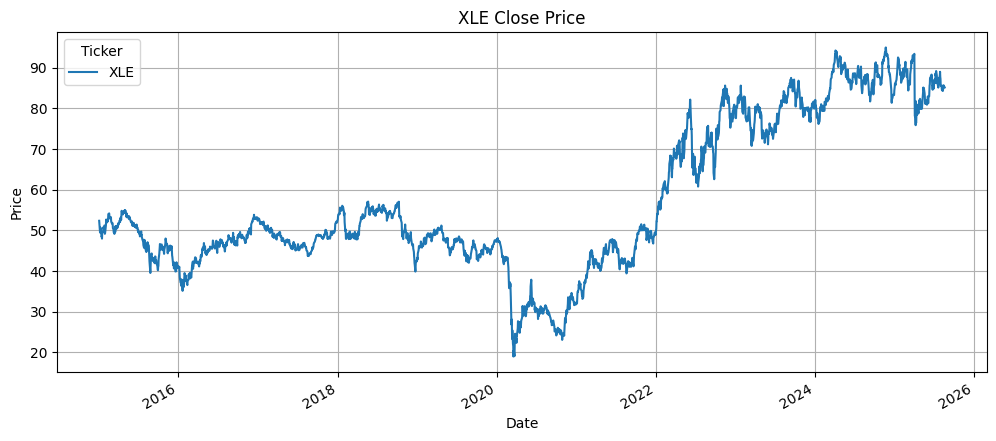

,,count,mean,min,25%,50%,75%,max,std
Price,Ticker,,,,,,,,
Date,,2673,2020-04-23 22:45:39.393939456,2015-01-02 00:00:00,2017-08-28 00:00:00,2020-04-24 00:00:00,2022-12-16 00:00:00,2025-08-19 00:00:00,NaN
Close,XLE,2673.0,56.926769,18.930193,45.315216,49.541851,75.787178,94.941917,18.307162


In [5]:
ax = df.plot(x="Date", y="Close", title=f"{TICKER} Close Price")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
plt.show()

df.describe().T


- Plot the closing price series.  
- Display summary statistics (mean, std, min, max).  

**Why:**  
- Visualization shows trends, seasonality, volatility.  
- Summary stats give a sense of distribution and scale.

## Interpreting the Summary Statistics

We plotted the historical **closing prices** of the XLE ETF and displayed its **summary statistics**.  
Here’s how to read and interpret them:

---

### 1. Date Column
- **min = 2015-01-02** → start of dataset.  
- **max = 2025-08-19** → end of dataset.  
- **count = 2673** → number of observations (≈ 10.5 years of trading days).  
- **mean date = 2020-04-23** → midpoint in the time span.  

This confirms we are working with ~10 years of **daily trading data** (only trading days, weekends/holidays excluded).

---

### 2. Close Price Column
- **count = 2673** → number of daily prices.  
- **mean = 56.93 USD** → average price over the whole period.  
- **min = 18.93 USD** → lowest price (COVID crash in 2020).  
- **25% = 45.31 USD** → lower quartile (25% of prices are below this).  
- **50% = 49.54 USD** → median (half the time below, half above).  
- **75% = 75.78 USD** → upper quartile.  
- **max = 94.94 USD** → highest price (energy boom in 2022–2023).  
- **std = 18.31** → standard deviation, showing high volatility.

---

### 3. Key Insights
- Prices mostly range between **45 and 76 USD**, but with large swings.  
- The **mean (57)** is higher than the **median (50)** → upward skew due to the strong rally after 2021.  
- **High volatility (std ~18)** means the ETF is riskier than stable sectors.  
- **Regime shifts** are visible:  
  - Crash to ~19 USD in 2020 (COVID).  
  - Rally to ~95 USD in 2022–2023 (energy boom, war in Ukraine, oil price spike).  

---

### 4. Why It Matters
- Understanding the **distribution of values** helps when choosing models (e.g., ARIMA vs ML).  
- The **volatility and regime changes** show why energy forecasting is hard but useful for hedge funds.  
- Always remember: **22 trading days ≈ 1 month** → we think in trading time, not calendar time.

---

## 4) Feature engineering

In [7]:
df_feat = add_time_features(df, ts_col="Date")
df_feat = make_lags(df_feat, y_col="Close", lags=(1,5,22))
df_feat = df_feat.dropna().reset_index(drop=True)

train, test = ts_train_test_split(df_feat, test_size=0.2)
y_tr, y_te = train["Close"].values, test["Close"].values

# Fix for multi-index columns
feature_cols = [c for c in df_feat.columns if isinstance(c, tuple) and c[0].startswith("lag_")] + \
			   [c for c in df_feat.columns if c[0] in ["month", "dayofweek", "year"]]
X_tr, X_te = train[feature_cols], test[feature_cols]


- Add calendar features (`year`, `month`, `dayofweek`).  
- Add lag features (`lag_1`, `lag_5`, `lag_22`).  
- Split into **train (80%) / test (20%)** sets.

**Why:**  
- ML needs features beyond raw prices.  
- Lag features = autoregressive signals (like ARIMA internally).  
- Chronological split avoids data leakage.


## 5) Baseline ARIMA

In [ ]:
arima = auto_arima(y_tr, seasonal=False, suppress_warnings=True)
arima_fc = arima.predict(n_periods=len(test))

m_arima = metrics(y_te, arima_fc)
print("ARIMA metrics:", m_arima)

plt.figure()
plt.plot(test["Date"], y_te, label="Actual")
plt.plot(test["Date"], arima_fc, label="ARIMA")
plt.legend(); plt.title(f"ARIMA vs Actual — {TICKER}"); plt.show()


- Fit an **ARIMA model** on the training set.  
- Forecast over the test horizon.  
- Compute metrics and plot predictions vs actuals.  

**Why:**  
- ARIMA = standard baseline for univariate time series.  
- Provides a benchmark to compare against ML/DL models.

## 6) Machine Learning with LightGBM

In [ ]:
lgbm = lgb.LGBMRegressor(
    n_estimators=800, learning_rate=0.02,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42
)
lgbm.fit(X_tr, y_tr)
lgbm_fc = lgbm.predict(X_te)

m_lgbm = metrics(y_te, lgbm_fc)
print("LightGBM metrics:", m_lgbm)

plt.figure()
plt.plot(test["Date"], y_te, label="Actual")
plt.plot(test["Date"], lgbm_fc, label="LightGBM")
plt.legend(); plt.title(f"LightGBM vs Actual — {TICKER}"); plt.show()


- Train a **LightGBM regressor** on lag + calendar features.  
- Predict test prices.  
- Evaluate with MAE, RMSE, MAPE.  

**Why:**  
- Shows how boosting handles time series with engineered features.  
- Often outperforms ARIMA if features capture enough structure.

## 7) Compare ARIMA vs LightGBM

In [ ]:
plt.figure()
plt.plot(test["Date"], y_te, label="Actual")
plt.plot(test["Date"], arima_fc, label="ARIMA")
plt.plot(test["Date"], lgbm_fc, label="LightGBM")
plt.legend(); plt.title(f"Forecast Comparison — {TICKER}")
plt.show()

print("ARIMA:", m_arima)
print("LightGBM:", m_lgbm)


- Plot **Actual vs ARIMA vs LightGBM** on the same graph.  
- Print side-by-side metrics.  

**Why:**  
- Direct visual + quantitative comparison → strengths/weaknesses are clear.  
- Hedge funds care about relative performance of models.

## 8) Next steps

- Add **exogenous variables** (e.g., natural gas `NG=F`, weather).
- Implement **walk‑forward** validation (see notebook 02).
- Hyperparameter tuning (Optuna/Bayesian search).
- Add LSTM comparison (see notebook 03).

**Why:**  
- Shows roadmap: this is just the MVP.  
- Recruiters/reviewers see you know how to extend the project.